# MATH 468 - Stochastic Calculus II - HW 4

In [1]:
'''Packages Used'''
import pandas as pd
import numpy as np
import datetime

'''Plotting Functionality'''
import matplotlib.pyplot as plt
# Used in my IDE
# plt.style.use('dark_background')

'''Code Deck Import'''
from StoCalCodeDeck import walk_params

'''Data Import Packages'''
import yfinance as yf

## Problem 1 (American options with N large)

*Note*: This problem is a continuation of Problem 3 in HW #3. The objective is to generalize your code to American options. Please provide the answers to the questions below as well as a sample of your code.

We consider the same market model as in Problem 3 of HW #3. We consider an American put option with strike price $K = \$1,025$ and maturity $T = 1$ year.

(a) Find the price of the option at time $t_0 = 0$ if it is American and compare with the price of the European put found in Problem 1.  
(b) What is the earliest possible time of optimal exercise of the American put?  
(c) Repeat questions (a) and (b) in the case where $r = 0\%$. What do you conclude?  

### Solution to Part (a)

In [2]:
'''Expanding the Function to Include American/European Nature of the Option'''

def build_tree(N, T, mu, sigma, s0, k, r, option_type, nature):
    '''
    Function Designed to Price Options using a Binomial Tree
    ---
    N - Number of Perids
    T - Time to Maturity (in years)
    mu - Assumed drift term (likely estimated)
    sigma - Assume vol term (likely estimated)
    s0 - Current asset price
    k - strike price
    r - interest rate (risk-free)
    option_type - Call or Put
    nature - american or european
    '''

    '''Establish change in time used'''
    dt = T / N

    '''Establish up and down factos'''
    u = np.exp(mu*dt + sigma*np.sqrt(dt))
    d = np.exp(mu*dt - sigma*np.sqrt(dt))
    
    '''Establish risk neutral probability'''
    q = ((1+r*dt) - d) / (u - d)
    
    '''Constructs the data frame -- each column and its representation
    index - number
    layer - time step
    stock_price - stock price at that node and layer
    phi - shares in replicating protfolio
    psi - amount of funds in money market
    option value - option price at that node'''
    tree = pd.DataFrame(data=None, index=range(0,sum(range(N+2))))
    tree.index.name = 'node'
    tree['layer'] = ""
    tree['stock_price'] = 0
    tree['phi'] = 0
    tree['psi'] = 0
    
    '''inputs intial stock price'''
    tree['stock_price'].loc[0] = s0

    '''Inputs layers (time steps) and further stock prices'''
    node = 0
    for i in range(0,N+2):
        if i < (N+1):
            tree.iloc[range(node,node+i+1),0] = i #Layer
            tree.iloc[range(node,node+i+1),1] = s0 * d ** (np.arange(i,-1,-1)) * u ** (np.arange(0,i+1,1)) #Stock Price
            node += i + 1

    '''Puts intrinsic option value in at every node'''
    if option_type == 'c':
        tree['option_value'] = tree['stock_price'].apply(lambda x: x-k if x-k > 0 else 0)
    elif option_type == 'p':
        tree['option_value'] = tree['stock_price'].apply(lambda x: k-x if k-x > 0 else 0)
    
    '''resets node to N-1'''
    node= node - N
    
    '''Calculates option value and replicating portfolio going backwards'''
    for i in reversed(range(N)):
        price_range = (1 / (1+r*dt)) * (q * tree.iloc[range(node,node+i+1),4].to_numpy() + 
                        (1-q) * tree.iloc[range(node-1,node+i),4].to_numpy()) # price option
        if nature == 'european':
            tree.iloc[range(node-i-2,node-1),4] = price_range
        elif nature == 'american':
            tree.iloc[range(node-i-2,node-1),4] = np.maximum(price_range, 
                            tree.iloc[range(node-i-2,node-1),4].to_numpy())
        tree.iloc[range(node-i-2,node-1),2] = ((tree.iloc[range(node,node+i+1),4].to_numpy() - 
                                            tree.iloc[range(node-1,node+i),4].to_numpy()) / 
                                            (tree.iloc[range(node,node+i+1),1].to_numpy() - 
                                            tree.iloc[range(node-1,node+i),1].to_numpy())) # get delta
        tree.iloc[range(node-i-2,node-1),3] = ((tree.iloc[range(node,node+i+1),4].to_numpy() - 
                                            tree.iloc[range(node-i-2,node-1),2].to_numpy() * 
                                            tree.iloc[range(node,node+i+1),1].to_numpy()) / 
                                            (1 + r*dt)) # Money Market
        node = node - i - 1

    return tree

In [3]:
'''Value the American Put'''
T=1 # 1 Year
N=60 # 60 Periods
mu, sigma = walk_params(u=0.005,d=0.003,T=T,N=N)
tree_a = build_tree(N=N, T=T, mu=mu, sigma=sigma, s0=1000, k=1025, r=0.05, option_type='p', nature='american')
print('the price of the american put is ${:.2f}'.format(tree_a.iloc[0,-1]))

C:\Users\jdean\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


the price of the american put is $25.00


In [4]:
'''Value of European Put'''
tree_e = build_tree(N=N, T=T, mu=mu, sigma=sigma, s0=1000, k=1025, r=0.05, option_type='p', nature='european')
tree_e.iloc[0,:]
print('the price of the european put is ${:.2f}'.format(tree_e.iloc[0,-1]))

the price of the european put is $3.57


The price of the European Put is $\$3.59$ while the American is $\$25.00$, which makes sense as the underlying currently trades $\$25$ cheap to the strike.  Therefore, one could buy the put and exercise it immediately to earn $\$25$ in P&L, while the european put would require waiting until expiry.

### Solution to Part (b)

In [5]:
'''Earliest Exercise'''
exercise = tree_a[tree_a['option_value'] == (1025 - tree_a['stock_price'])].iloc[0,0]
print('The earliest optimal exercise is at time {:.0f}'.format(exercise))

The earliest optimal exercise is at time 0


### Solution to Part (c)

In [6]:
'''Value the American Put, 0 rates'''
T=1 # 1 Year
N=60 # 60 Periods
mu, sigma = walk_params(u=0.005,d=0.003,T=T,N=N)
tree_a = build_tree(N=N, T=T, mu=mu, sigma=sigma, s0=1000, k=1025, r=0, option_type='p', nature='american')
print('the price of the american put is ${:.2f}'.format(tree_a.iloc[0,-1]))

the price of the american put is $28.60


In [7]:
exercise = tree_a[tree_a['option_value'] == (1025 - tree_a['stock_price'])].iloc[0,0]
print('The earliest optimal exercise is at time {:.0f}'.format(exercise))

The earliest optimal exercise is at time 38


In [8]:
tree_e = build_tree(N=N, T=T, mu=mu, sigma=sigma, s0=1000, k=1025, r=0, option_type='p', nature='european')
tree_e.iloc[0,:]
print('the price of the european put is ${:.2f}'.format(tree_e.iloc[0,-1]))

the price of the european put is $28.60


The options trade at the same price as there is no market drift to push the stock price up.  This makes the european put more valuable.  Additionally, the earliest exercise for the put is so far out it is having little effect on its value.

## Problem 2 (Option pricing from real data.)

*Note*: This problem is the continuation of Prob. 3 in HW #1. We will use the data to price options and compare with the market prices.

Consider the asset that you selected in HW #1. For this asset, select three call options and one put option. All options should have approximately the same expiration date, say about 3 months in the future. The three calls should have three different strike prices, typically one *in-the-money*, one *at-the-money*, and one *out-of-the-money*. (Consider values relatively close to the current price and, if you have access to this information, for which the trading volume is relatively large.) The put option should be *at-the-money*. Record the current price of these options. Note that all traded options are American options. Also determine the interest rate to be used for your calculations: typically, you can consider the LIBOR rate, or the 10-year US treasury yield.

(a) We assume that the CRR model represents the stock price and that its assumptions are satisfied. Based on historical data (about 3 months to a year in the past), determine the parameters $\mu$ and $\sigma$ for the stock that you chose following the methods discussed in class. (I recommend to download current data, but feel free to use past data if that is all you have.)  
(b) Price the selected put option using an $N$-period binomial model for different values of $N$ (which you can choose on your own). As a hint, you can for instance start with $N = 2$ or $N = 3$, which should be approximately monthly-periods. You can then use approximately weekly periods ($N \approx 10$ or $N \approx 12$) or daily periods ($N \approx 60$). Make sure that you use the exact number of days or weeks to the maturity of your option.  
(c) Compare your results to the market price and comment. In particular, discuss the impact of $N$ on your calculated price.  
(d) Price each of the three selected call options using all of (i) approximately monthly periods ($N = 2, 3$), (ii) approximately weekly periods ($N \approx 10, 12$), and (iii) daily periods ($N \approx 60$).  
(e) Compare your results to the market prices and comment. In particular, discuss the impact of the strike price $K$ on your results. In general, once you obtain the parameters $\mu$ and $\sigma$, you should be able to use the computing tool that you developed in HW#3 and in Problem 1 to price your options.


In [9]:
def asset_data(ticker, start_date, end_date):
    '''
    Function Designed to Pull Equity Data
    ----
    ticker - Ticker of desired equity
    start_date -  Date to start pulling data from
    end_data - Date to end data pull, typically today
    '''
    if type(start_date) == datetime.datetime:
        start_date = start_date.strftime('%Y-%m-%d')
    else:
        pass
    
    if type(end_date) == datetime.datetime:
        end_date = end_date.strftime('%Y-%m-%d')
    else:
        pass

    asset = yf.Ticker(ticker)
    data = yf.download(ticker, start_date, end_date)                                # Pull Data
    
    return asset, data

def maturity(timedelta, asset):
    '''
    Function Designed to find option expiry closest to desired expiry
    ----
    timedelta - time until expiry (EXPRESSED IN YEARS)
    asset - yfinance.ticker.Ticker object whos options are being analyzed
    '''
    days = timedelta*365                                                            # Time Expressed in years converted to days
    expiries = asset.options
    distance = []
    for expiry in expiries:                                                         # Calculate Distance from Desired Expiry
        distance.append(abs(datetime.datetime.strptime(expiry, '%Y-%m-%d') - 
                    (datetime.datetime.today() + 
                    datetime.timedelta(days))))

    expiry = expiries[distance.index(min(distance))]                                # Use minimum distance
    years_to_expiry = float((datetime.datetime.strptime(expiry, '%Y-%m-%d') - datetime.datetime.today()).days) / 365
    return expiry, years_to_expiry

def rates_data():
    '''
    Function designed to pull current yield on the US 10 year note
    NOTE: Pulls the value as a number, not a percentage
    '''
    rates = yf.download('^tnx', datetime.datetime.today())
    rf = rates['Adj Close'][0] / 100
    return rf

In [10]:
'''Get ETF Data'''
etf, etf_data = asset_data(ticker = 'LQD', start_date='2017-01-01', end_date=datetime.datetime.today())
expiry, years_to_expiry = maturity(0.25, etf)
px_last = etf_data.iloc[-1,3]

'''Get Option Data'''
options = etf.option_chain(expiry)
calls = options.calls
puts = options.puts
itm_calls = calls[calls['strike'] < px_last - 0.5]
atm_calls = calls[(calls['strike'] < px_last+0.5) & (calls['strike'] > px_last-0.5)]
otm_calls = calls[calls['strike'] > px_last + 0.5]
atm_puts = puts[(puts['strike'] < px_last+0.5) & (puts['strike'] > px_last-0.5)]
atm_k = atm_calls['strike'].to_list()[0]
otm_k = 126             # Chosen arbitrarily
itm_k = 120             # Only ITM call left

'''Get Rates Data'''
rf = rates_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Solution to Part (a)

In [11]:
def estimate_params(M, data):
    '''
    Function designed to estimate Mu and Sigma parameters for use in Option Pricing
    ---
    M - Sample Size to consider
    data - Asset DataFrame pulled from Asset_Data() function
    '''

    dt = 1/252                                              # 1 day timestep
    
    y = np.log(1 + data['Adj Close'].pct_change())[-M:]     # Log Returns
    
    sigma_sq = np.var(y) / dt
    sigma = np.sqrt(sigma_sq)                               # Sigma Estimator

    mu = np.mean(y) / dt + 0.5*sigma_sq                     # Mu Estimator
    
    return mu, sigma

In [12]:
lqd_mu, lqd_sigma = estimate_params(M = 500, data = etf_data)
print('The mean estimator is {:.2%}'.format(lqd_mu))
print('The vol estimator is {:.2%}'.format(lqd_sigma))
print('The rates estimator is {:.2%}'.format(rf))

The mean estimator is 4.98%
The vol estimator is 12.11%
The rates estimator is 1.87%


### Solution to Part (b)

In [13]:
option_prices = []
n_cases = [2,3,5,7,10,12,20,25,30,40,50,55,60,75,100]

for n in n_cases:
    lqd_p_tree = build_tree(N=n, T=years_to_expiry, mu=lqd_mu, sigma=lqd_sigma, s0=px_last, k=atm_k, r=rf, option_type='p', nature='american')
    option_prices.append(lqd_p_tree.iloc[0,4])

Text(0, 0.5, 'Price of the Option')

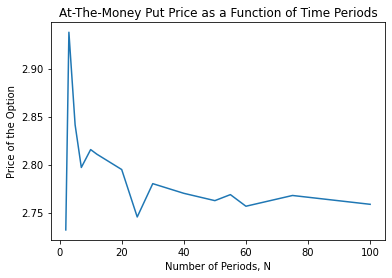

In [14]:
plt.plot(n_cases,option_prices)
plt.title('At-The-Money Put Price as a Function of Time Periods')
plt.xlabel('Number of Periods, N')
plt.ylabel('Price of the Option')

### Solution to Part (c)

Depending on the choice of $N$, we see the price of the option decaying exponentially from $\$2.95$ to $\$2.75$.  We see the at-the-money put has a strike of $\$122$ but was last traded on February 28th, so the $\$2.02$ does not reflect the current market price of the option.  We refer to the market on the security which is currently $\$3.80$ at $\$4.40$.  We see our theoretical price is below the current market but above the last traded price.  This is likely due to recent world events that have increased volatility in the market.

In [15]:
atm_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
16,LQD220617P00122000,2022-02-28 16:19:31+00:00,122.0,2.02,3.75,5.0,0.0,0.0,20.0,3769,0.18409,True,REGULAR,USD


### Solution to Part (d) & (e)

C:\Users\jdean\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'Price of the Option')

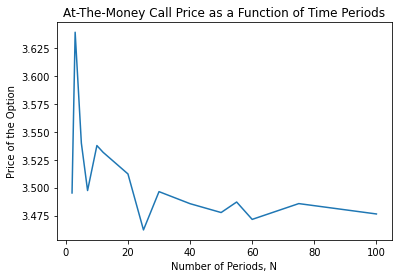

In [16]:
'''ATM Call Price Sensitivity'''
option_prices = []

for n in n_cases:
    lqd_p_tree = build_tree(N=n, T=years_to_expiry, mu=lqd_mu, sigma=lqd_sigma, s0=px_last, k=atm_k, r=rf, option_type='c', nature='american')
    option_prices.append(lqd_p_tree.iloc[0,4])

plt.plot(n_cases, option_prices)
plt.title('At-The-Money Call Price as a Function of Time Periods')
plt.xlabel('Number of Periods, N')
plt.ylabel('Price of the Option')

In [17]:
atm_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
1,LQD220617C00122000,2022-02-15 16:35:27+00:00,122.0,3.3,2.18,3.1,0.0,0.0,NaN,3,0.132577,False,REGULAR,USD


The At-The-Money Call is pricing $\$3.45$ at $\$3.63$, while the traded market is $\$2.20$ at $\$3.35$.  This is farily close to the traded market

C:\Users\jdean\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'Price of the Option')

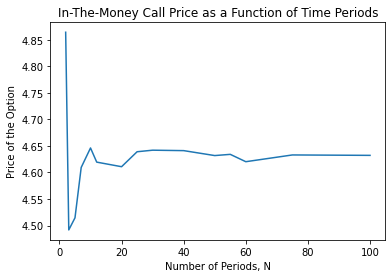

In [18]:
'''ITM Call Price Sensitivity'''
option_prices = []

for n in n_cases:
    lqd_p_tree = build_tree(N=n, T=years_to_expiry, mu=lqd_mu, sigma=lqd_sigma, s0=px_last, k=itm_k, r=rf, option_type='c', nature='american')
    option_prices.append(lqd_p_tree.iloc[0,4])

plt.plot(n_cases, option_prices)
plt.title('In-The-Money Call Price as a Function of Time Periods')
plt.xlabel('Number of Periods, N')
plt.ylabel('Price of the Option')

The In-The-Money Call is pricing $\$4.55$ at $\$4.80$, while the traded market is $\$10.95$ at $\$14.95$.  This is not close to the traded market and is likely due to the strike being at the absolute end of the option chain (a $\$120$ is the minimum strike)

In [19]:
itm_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,LQD220617C00120000,2021-11-10 11:49:25+00:00,120.0,17.16,10.95,14.95,0.0,0.0,4.0,3,0.563908,True,REGULAR,USD


C:\Users\jdean\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'Price of the Option')

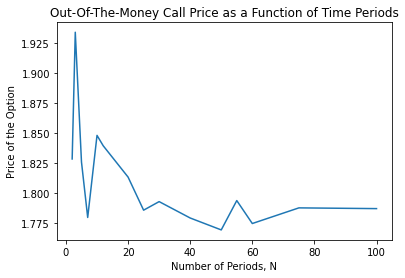

In [20]:
'''OTM Call Price Sensitivity'''
option_prices = []

for n in n_cases:
    lqd_p_tree = build_tree(N=n, T=years_to_expiry, mu=lqd_mu, sigma=lqd_sigma, s0=px_last, k=otm_k, r=rf, option_type='c', nature='american')
    option_prices.append(lqd_p_tree.iloc[0,4])

plt.plot(n_cases, option_prices)
plt.title('Out-Of-The-Money Call Price as a Function of Time Periods')
plt.xlabel('Number of Periods, N')
plt.ylabel('Price of the Option')

In [21]:
otm_calls[otm_calls['strike'] == otm_k]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
5,LQD220617C00126000,2022-03-02 15:33:44+00:00,126.0,1.13,0.61,1.52,0.0,0.0,10.0,5040,0.127999,False,REGULAR,USD


The Out-Of-The-Money Call is prcing $\$1.77$ at $\$1.93$, while the traded market is $\$0.64$ at $\$1.22$.  This is fairly close to the traded market.

The priced options were generally close to their traded market, but likely differed due to recent market volatility in the security.

## Problem 3

We consider an N-period binomial model with the following properties: each period lasts a year and the current stock price is S0 = 4. On each period, the stock price doubles when it moves up and is reduced by half when it moves down. The annual interest rate on the money market is $25\%$.

(a) Find the values of $\mu$ and $\sigma$ associated with this CRR model.  
(b) Assuming that $p = \frac{1}{2}$, find $P(S_T > 6)$ when $N = 3$ and $N = 10$.  
(c) Using the risk-neutral option pricing formula (written as an expectation), calculate the price of a European call with strike price $K = 8$ when $N = 3$ and $N = 10$.


### Solution to Part (a)

In [22]:
years = 5
mu, sigma = walk_params(u=1,d=.5,T=years,N=years)
print('The mean estimator is {:.2%}'.format(mu))
print('The vol estimator is {:.2%}'.format(sigma))

The mean estimator is 0.00%
The vol estimator is 69.31%


### Solution to Part (b)

This is clearly a binomial experiment where $N$ represents the time step.  By properties of the tree, its easy to see that there will be $N+1$ nodes and the median of the nodes will be $4$.  Therefore the probability can be represented in the following terms of a binomial distribution

$$P(S_T > 4) = \sum_{i = \lceil \frac{N}{2} + 1 \rceil}^{N}{N \choose i}(\frac{1}{2})^{N}$$

We can also see that given the doubling/halving property of the tree, the node above $4$ will always be $16$, therefore $P(S_T>4)=P(S_T>6)=P(S_T\geq16)$
$$\implies P(S_T > 6) = \sum_{i = \lceil \frac{N}{2} \rceil}^{N}{N \choose i}(\frac{1}{2})^{N}$$

$N=3$ Case
$$P(S_T > 6) = \sum_{i = 2}^{3}{3 \choose i}(\frac{1}{2})^{3} = 3(\frac{1}{2})^3 + (\frac{1}{2})^3 = \frac{4}{2^3} = \frac{1}{2}$$

next
$N=10$ Case

$$P(S_T > 6) = \sum_{i = 6}^{10}{10 \choose i}(\frac{1}{2})^{10} = \frac{1 - {10 \choose 5}(\frac{1}{2})^{10}}{2} = 0.3770$$

### Solution to Part (c)

$$F_t = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[F_t|\mathcal{F}_t])$$
$$q = \frac{(1+r\Delta t) - d}{u-d} = \frac{(1+\frac{1}{4}(1)) - \frac{1}{2}}{2 - \frac{1}{2}} = \frac{\frac{3}{4}}{\frac{3}{2}} = \frac{1}{2}$$
$N=3$
We have
$$F_0 = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[\max\{0,S_3-8\}])$$
I partition on the event that $\{S_3\geq8\}$
$$F_0 = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[\max\{0,S_3-8\}|S_3\geq8]Q(S_3\geq8) + \mathbb{E}_{\mathcal{Q}}[\max\{0,S_3-8\}|S_3<8]Q(S_3<8))$$
This partitioning allows me to drop the max function when evaluating
$$F_0 = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[S_3-8|S_3\geq8]Q(S_3\geq8) + \mathbb{E}_{\mathcal{Q}}[0|S_3<8]Q(S_3<8))$$
We can then eliminate the 0 term
$$F_0 = \mathrm{PV}((\mathbb{E}_{\mathcal{Q}}[S_3|S_3\geq8]-8)Q(S_3\geq8))$$
Then by the definition of conditional expectation, we can evaluate this term.  Note that the sample space for time step 3 is $\Omega = \{\frac{1}{2},2,8,32\}$, which I index by $i\in\{0,1,2,3\}$.  We observe
$$F_0 = \mathrm{PV}((\sum_{i=2}^3\Omega_iQ(S_3=\Omega_i|S_3\geq8)-8)Q(S_3\geq8))$$
Rewriting the conditional expectations with the appropriate terms
$$F_0 = \mathrm{PV}(((8\frac{3}{4} + 32\frac{1}{4})-8)Q(S_3\geq8))$$
And then we present value the payoff and observe the following option price
$$F_0 = (\frac{1}{1+25\%})^3((6)\frac{1}{2}) = 1.5360$$
We then validate the price with the option pricing tool we have built earlier

In [23]:
mu,sigma = walk_params(u=1,d=.5,T=3,N=3)
print('The option is worth: ${:.2f}'.format(
    build_tree(N=3,T=3,mu=mu,sigma=sigma,s0=4,k=8,r=0.25, option_type='c',nature='european').iloc[0,-1]))

The option is worth: $1.54


C:\Users\jdean\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


$N=10$
We have
$$F_0 = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[\max\{0,S_{10}-8\}])$$
I partition on the event that $\{S_10\geq8\}$
$$F_0 = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[\max\{0,S_{10}-8\}|S_{10}\geq8]Q(S_{10}\geq8) + \mathbb{E}_{\mathcal{Q}}[\max\{0,S_{10}-8\}|S_{10}<8]Q(S_{10}<8))$$
This partitioning allows me to drop the max function when evaluating
$$F_0 = \mathrm{PV}(\mathbb{E}_{\mathcal{Q}}[S_{10}-8|S_{10}\geq8]Q(S_{10}\geq8) + \mathbb{E}_{\mathcal{Q}}[0|S_{10}<8]Q(S_{10}<8))$$
We can then eliminate the 0 term
$$F_0 = \mathrm{PV}((\mathbb{E}_{\mathcal{Q}}[S_3|S_{10}\geq8]-8)Q(S_3\geq8))$$
Then by the definition of conditional expectation, we can evaluate this term.  Note that the sample space for time step 10 is $\Omega = \{\frac{1}{256},\frac{1}{64},\frac{1}{16},\frac{1}{4},1,4,16,64,256,1024,4096\}$, which I index by $i\in\{0,1,2,3,4,5,6,7,8,9,10\}$.  I confirm these values in a code block below.  We observe
$$F_0 = \mathrm{PV}((\sum_{i=6}^{10}\Omega_iQ(S_{10}=\Omega_i|S_{10}\geq8)-8)Q(S_{10}\geq8))$$
Rewriting with the definition of conditional probability we see
$$F_0 = \mathrm{PV}((\sum_{i=6}^{10}\Omega_i \frac{Q(S_{10}=\Omega_i,S_{10}\geq8)}{Q(S_{10}\geq8)}-8)Q(S_{10}\geq8))$$
We see that the event $\{S_{10}=\Omega_i,S_{10}geq8\}$ is implied by the sum from the 6th index, so we drop the second part
$$F_0 = \mathrm{PV}((\sum_{i=6}^{10}\Omega_i \frac{Q(S_{10}=\Omega_i)}{Q(S_{10}\geq8)}-8)Q(S_{10}\geq8))$$
We substitute the probability notation for the functional notation of the binomial random variable
$$F_0 = \mathrm{PV}((\sum_{i=6}^{10}\Omega_i \frac{{10\choose i}(\frac{1}{2})^{10}}{0.3770}-8)Q(S_{10}\geq8))$$
We then write the sum out
$$F_0 = \mathrm{PV}((\frac{16{10\choose 6}(\frac{1}{2})^{10}+64{10\choose 7}(\frac{1}{2})^{10}+256{10\choose 8}(\frac{1}{2})^{10}+1024{10\choose 9}(\frac{1}{2})^{10}+4096{10\choose 10}(\frac{1}{2})^{10}}{0.3770}-8)Q(S_{10}\geq8))$$
And calculating the sum shows
$$F_0 = \mathrm{PV}((\frac{36.03125}{0.3770}-8)Q(S_{10}\geq8))$$
And further calculation shows
$$F_0 = \mathrm{PV}((87.5736)(0.3770))$$
Which finally brings us to this result
$$F_0 = (\frac{1}{1 + 25\%})^{10}((87.5736)(0.3770)) = 3.55$$
We validate the result in the code below

In [24]:
'''Builds 10 Step Tree'''
mu,sigma = walk_params(u=1,d=.5,T=10,N=10)
tree = build_tree(N=10,T=10,mu=mu,sigma=sigma,s0=4,k=8,r=0.25, option_type='c',nature='european')

In [25]:
'''Confirms S10 values+'''
tree[tree['layer']==10]['stock_price']

node
55       0.003906
56       0.015625
57       0.062500
58       0.250000
59       1.000000
60       4.000000
61      16.000000
62      64.000000
63     256.000000
64    1024.000000
65    4096.000000
Name: stock_price, dtype: float64

In [26]:
'''Prices Option'''
print('The option is worth: ${:.2f}'.format(tree.iloc[0,-1]))

The option is worth: $3.55
